In [1]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [2]:
# import data
ontario = pd.read_csv('C:/Users/allis/OneDrive/Documents/ARLIS/Ontario_USABidenTrump_Mar1-Aug1.csv')

ontario_english = ontario.loc[ontario['language'] == 'English'] # get English and French separated
ontario_eng_sample = ontario_english.sample(n=25000)
ontario_french = ontario.loc[ontario['language'] == 'French']

C:\Users\allis\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7,9,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Extract hashtags from ontario tweet body and create correlation heatmap

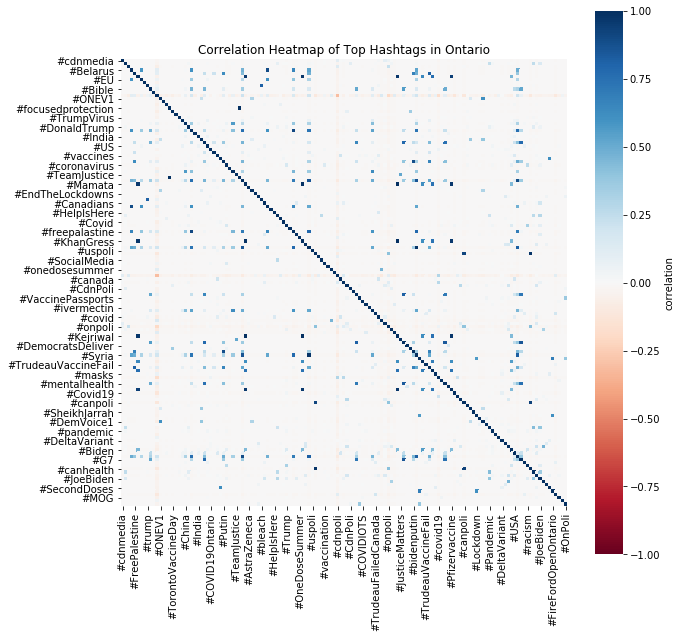

In [3]:
# define function to return hashtags
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

#create new column containing hashtags
ontario['hashtags'] = ontario.body.apply(find_hashtags)

# create separate data frame containing hashtags
hashtags_list_df = ontario.loc[ 
                       ontario.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']] 

# flatten hastags (one hashtag per row)
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

# count hashtags
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

# find popular hashtags appearing more than 10 times and create python set
min_appearance = 50
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

# make matrix of hashtags
for hashtag in popular_hashtags_set:
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
seaborn.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'}).set(title='Correlation Heatmap of Top Hashtags in Ontario')
plt.show()

Create functions for cleaning tweet text

In [4]:
# functions for text cleaning

def remove_links(tweet):
    '''Takes a string and removes links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

def remove_emoji(string):
    ''' Takes a string and removes all emojis using unicode'''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def fix_quotes(tweet):
    ''' Takes a string and replaces curly quotation marks'''
    tweet = tweet.replace(u'\u201c', '\'') # replacing curly quotes
    tweet = tweet.replace('”', '\'') 
    tweet = tweet.replace('’', '\'')
    return tweet

<>:12: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<ipython-input-4-01fa1c0267c7>:12: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet


In [5]:
# clean English tweets
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# English master function
def clean_tweet(tweet, bigrams=False):
    '''Takes a string and returns uniform stemmed words and bigrams'''
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_emoji(tweet)
    tweet = tweet.lower() # lower case
    tweet = fix_quotes(tweet)
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

<>:15: DeprecationWarning: invalid escape sequence \s
<>:15: DeprecationWarning: invalid escape sequence \s
<>:15: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-a41ea51776ae>:15: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet) #remove double spacing


In [6]:
# clean French tweets

my_french_stopwords = nltk.corpus.stopwords.words('french')

# French master function
def clean_tweet_french(tweet, bigrams=False):
    '''Takes a string and returns uniform stemmed words and bigrams'''
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_emoji(tweet)
    tweet = tweet.lower() # lower case
    tweet = fix_quotes(tweet)
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_french_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

<>:14: DeprecationWarning: invalid escape sequence \s
<>:14: DeprecationWarning: invalid escape sequence \s
<>:14: DeprecationWarning: invalid escape sequence \s
<ipython-input-6-ece819733a73>:14: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet) #remove double spacing


Apply text cleaning functions to data frames

In [7]:
ontario_eng_sample['clean_text'] = ontario_eng_sample.body.apply(clean_tweet)

ontario_french['clean_text'] = ontario_french.body.apply(clean_tweet_french)

C:\Users\allis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Generate tokenized words from texts

In [31]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

#generate english tokenized words
eng_data_words = gen_words(ontario_eng_sample.clean_text)
print (eng_data_words[0:3])

[['ok', 'great', 'lift', 'export', 'ban', 'vaccin', 'dose', 'canada', 'year', 'old', 'plu', 'senior', 'stay', 'home', 'wear', 'mask', 'sinc', 'begin', 'keep', 'wait', 'get', 'shot'], ['roll', 'johnson', 'johnson', 'vaccin', 'secur', 'enough', 'dose', 'everi', 'american', 'end', 'may', 'last', 'week', 'big', 'week', 'still', 'go', 'pleas', 'keep', 'wear', 'mask', 'stay', 'social', 'distanc', 'get', 'vaccin', 'turn'], ['ask', 'thought', 'us', 'offer', 'vaccin', 'canada', 'doug', 'ford', 'thank', 'trump', 'biden', 'make', 'kind', 'stuff']]


list

Create bigrams and trigrams from tokenized words using gensim

In [41]:
# English bigrams and trigrams
eng_bigram_phrases = gensim.models.Phrases(eng_data_words, min_count=5, threshold=25) # look for bigrams
eng_trigram_phrases = gensim.models.Phrases(eng_bigram_phrases[eng_data_words], threshold=25) #use bigrams to look for trigrams

eng_bigram = gensim.models.phrases.Phraser(eng_bigram_phrases) # create bigram and trigram phrases
eng_trigram = gensim.models.phrases.Phraser(eng_trigram_phrases)

def make_bigrams(texts):
    return([eng_bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([eng_trigram[eng_bigram[doc]] for doc in texts])

eng_data_bigrams = make_bigrams(eng_data_words) # run function to add bigrams and trigrams
eng_data_bigrams_trigrams = make_trigrams(eng_data_bigrams)

print (eng_data_bigrams_trigrams[0:4])

[['ok', 'great', 'lift_export_ban', 'vaccin', 'dose', 'canada', 'year_old', 'plu', 'senior', 'stay_home', 'wear_mask', 'sinc_begin', 'keep', 'wait', 'get', 'shot'], ['roll', 'johnson_johnson', 'vaccin', 'secur', 'enough', 'dose', 'everi', 'american', 'end_may', 'last_week_big', 'week', 'still', 'go', 'pleas', 'keep', 'wear_mask', 'stay', 'social_distanc', 'get', 'vaccin', 'turn'], ['ask_thought_us', 'offer', 'vaccin', 'canada', 'doug_ford', 'thank', 'trump', 'biden', 'make_kind_stuff'], ['biden', 'announc', 'nomin', 'christi', 'grimm', 'perman', 'inspector', 'gener', 'health_human_servic', 'trump', 'attack', 'issu', 'report', 'amid', 'pandem', 'detail', 'shortag', 'ppe', 'tri', 'replac', 'trump', 'nomine', 'never', 'confirm']]


Remove low value words from corpus

In [10]:
'''
from gensim.models import TfidfModel

eng_id2word = corpora.Dictionary(eng_data_bigrams_trigrams)

eng_texts = eng_data_bigrams_trigrams

eng_corpus = [eng_id2word.doc2bow(text) for text in eng_texts]

eng_tfidf = TfidfModel(eng_corpus, id2word=eng_id2word)

low_value = 0.03
eng_words  = []
eng_words_missing_in_tfidf = []
for i in range(0, len(eng_corpus)):
    bow = eng_corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in eng_tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in eng_tfidf[bow] if value < low_value]
    drops = low_value_words+eng_words_missing_in_tfidf
    for item in drops:
        eng_words.append(eng_id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in eng_words_missing_in_tfidf]
    eng_corpus[i] = new_bow

print (eng_corpus[0][0:20])
'''

'\nfrom gensim.models import TfidfModel\n\neng_id2word = corpora.Dictionary(eng_data_bigrams_trigrams)\n\neng_texts = eng_data_bigrams_trigrams\n\neng_corpus = [eng_id2word.doc2bow(text) for text in eng_texts]\n\neng_tfidf = TfidfModel(eng_corpus, id2word=eng_id2word)\n\nlow_value = 0.03\neng_words  = []\neng_words_missing_in_tfidf = []\nfor i in range(0, len(eng_corpus)):\n    bow = eng_corpus[i]\n    low_value_words = []\n    tfidf_ids = [id for id, value in eng_tfidf[bow]]\n    bow_ids = [id for id, value in bow]\n    low_value_words = [id for id, value in eng_tfidf[bow] if value < low_value]\n    drops = low_value_words+eng_words_missing_in_tfidf\n    for item in drops:\n        eng_words.append(eng_id2word[item])\n    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]\n\n    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in eng_words_missing_in_tfidf]\n    eng_corpus[i] = new_bow\n\nprint (eng_corpus[0][0:20])\n'

In [42]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents
id2word = Dictionary(eng_data_bigrams_trigrams)

# Filter out words that occur less than 20 documents, or more than 95% of the documents
id2word.filter_extremes(no_below=20, no_above=0.9)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in eng_data_bigrams_trigrams]

print (corpus[0:3][0:20])

word = id2word[[0][:1][0]]
print (word)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [(1, 1), (2, 1), (4, 1), (10, 2), (12, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(0, 1), (10, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)]]
canada


Run model and create visualization

In [43]:
# English LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=500,
                                            passes=10,
                                            alpha="auto")

In [44]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.377990  0.261505       1        1  37.287980
8      0.125198  0.441706       2        1  15.520222
7     -0.362166 -0.269088       3        1  11.386773
4     -0.252682  0.421591       4        1   9.446736
3      0.201634 -0.442928       5        1   7.509834
9     -0.166061  0.151276       6        1   4.626031
5     -0.107146 -0.405810       7        1   4.349467
2     -0.472743  0.030892       8        1   3.909558
0      0.184853 -0.091166       9        1   3.091670
1      0.471126 -0.097977      10        1   2.871729, topic_info=          Term          Freq         Total Category  logprob  loglift
28       biden   6813.000000   6813.000000  Default  10.0000  10.0000
32       trump   7602.000000   7602.000000  Default   9.0000   9.0000
10      vaccin  13467.000000  13467.000000  Default   8.0000   8.0000
48       covid  10441.000000  10441.000000  Default   7.0000   7.0000
41      pandem   3105.000000   3105.000000  Default   6.0000   6.0000
...        ...           ...           ...      ...      ...      ...
1218    reason    225.080302    225.973466  Topic10  -3.6946   3.5463
746       hold    218.448635    219.341801  Topic10  -3.7245   3.5462
689   investig    193.017773    193.910891  Topic10  -3.8482   3.5456
108      liber    175.220785    176.113903  Topic10  -3.9450   3.5452
1553       buy    160.556397    161.449535  Topic10  -4.0324   3.5447

[118 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
82        3  0.999265  administr
253       5  0.997162      allow
1788      8  0.995663     almost
464       2  0.999205       also
14        1  0.999836   american
...     ...       ...        ...
250       4  0.998977       work
135       1  0.105780      would
135       2  0.893249      would
273       8  0.998221       year
349       4  0.996785        yet

[116 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 8, 5, 4, 10, 6, 3, 1, 2])

In [46]:
print(lda_model.print_topics())

[(0, '0.036*"reopen" + 0.032*"bad" + 0.029*"safe" + 0.022*"remind" + 0.021*"chang" + 0.020*"guy" + 0.020*"hous" + 0.019*"donat" + 0.016*"strategi" + 0.015*"mask_mandat"'), (1, '0.075*"trudeau" + 0.044*"ontario" + 0.044*"media" + 0.029*"team" + 0.027*"origin" + 0.025*"reason" + 0.024*"hold" + 0.021*"investig" + 0.019*"liber" + 0.018*"buy"'), (2, '0.082*"die" + 0.051*"year" + 0.033*"ask" + 0.027*"hospit" + 0.025*"caus" + 0.024*"question" + 0.018*"due" + 0.018*"nearli" + 0.017*"almost" + 0.017*"unvaccin"'), (3, '0.051*"new" + 0.040*"state" + 0.027*"lockdown" + 0.027*"border" + 0.026*"rate" + 0.024*"come" + 0.022*"stop" + 0.021*"open" + 0.018*"approv" + 0.018*"allow"'), (4, '0.043*"want" + 0.030*"work" + 0.026*"support" + 0.023*"even" + 0.022*"see" + 0.019*"travel" + 0.018*"mask" + 0.014*"yet" + 0.013*"school" + 0.013*"believ"'), (5, '0.060*"republican" + 0.038*"job" + 0.032*"famili" + 0.023*"relief_bill" + 0.020*"pass" + 0.020*"economi" + 0.017*"american_rescu_plan" + 0.016*"asian" + 0.01

Get topic probability

In [48]:
l=[lda_model.get_document_topics(item) for item in corpus]

In [49]:
print(l[500])

[(0, 0.014713935), (1, 0.013633575), (2, 0.038768083), (3, 0.11678593), (4, 0.13812523), (5, 0.02018519), (6, 0.40148908), (7, 0.0941393), (8, 0.099648595), (9, 0.06251105)]


Get dominant topic and percentage contribution for each document (tweet)

In [51]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=eng_data_bigrams_trigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#7.-The-most-representative-sentence-for-each-topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.4231,"vaccin, covid, american, peopl, canada, get, u...","[ok, great, lift_export_ban, vaccin, dose, can..."
1,1,6.0,0.5458,"vaccin, covid, american, peopl, canada, get, u...","[roll, johnson_johnson, vaccin, secur, enough,..."
2,2,6.0,0.3873,"vaccin, covid, american, peopl, canada, get, u...","[ask_thought_us, offer, vaccin, canada, doug_f..."
3,3,9.0,0.2443,"vote, democrat, relief, polit, tri, bill, reme...","[biden, announc, nomin, christi, grimm, perman..."
4,4,6.0,0.4459,"vaccin, covid, american, peopl, canada, get, u...","[scientif_paper_publish, mani_exampl_ivermecti..."
5,5,6.0,0.4604,"vaccin, covid, american, peopl, canada, get, u...","[biden, announc, month, action, today, tri, pu..."
6,6,6.0,0.2891,"vaccin, covid, american, peopl, canada, get, u...","[republican, believ, covid, chines, bioweapon,..."
7,7,6.0,0.4755,"vaccin, covid, american, peopl, canada, get, u...","[claim, spike, protein, toxic, get, vaccin, we..."
8,8,6.0,0.4372,"vaccin, covid, american, peopl, canada, get, u...","[governor, mcmaster, unnecessari, childish, fi..."
9,9,6.0,0.3594,"vaccin, covid, american, peopl, canada, get, u...","[inner, child, trumpers]"


Get documents which best represent each topic

In [52]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,3.0,0.2962,"new, state, lockdown, border, rate, come, stop, open, approv, allow","[rememb, trump, brag, market, charg, rememb, non, stop, brag, like, god, charg, wealth]"
1,4.0,0.3350,"want, work, support, even, see, travel, mask, yet, school, believ","[dr_anthoni_fauci, suggest, parent, follow, new, covid, guidanc, mask_wear, issu, american_acade..."
2,6.0,0.6534,"vaccin, covid, american, peopl, canada, get, usa, us, unit_state, one","[canada, usa, two, nation, share, niagarafalls, qualiti, democraci, usa, th, canada, th, best, c..."
3,7.0,0.3894,"biden, presid, say, million, day, dose, administr, joe, make, coronaviru","[presid, joe, biden, say, unit_state, reach_goal, administ, million, vaccin, dose, tomorrow, th,..."
4,8.0,0.4258,"trump, pandem, would, know, said, call, right, think, also, live","[fuck, trump, fuck, democrat, fuck, news, fuck, great_reset, fuck, covid, fuck, blm, fuck, proud..."
5,9.0,0.2443,"vote, democrat, relief, polit, tri, bill, rememb, fund, claim, lot","[biden, announc, nomin, christi, grimm, perman, inspector, gener, health_human_servic, trump, at..."


Sort top n most representative documents for each topic

In [57]:
def get_best_docs(df, n, k, texts):
    '''Return the index of the n most representative documents from a list of topic responsibilities for each topic'''
    '''n is the number of douments you want, k is the number of topics in the model, the texts are the FULL texts used to fit the model'''
    #create column list to iterate over
    k_cols = range(0, k)

    #intialize empty list to hold results
    n_rep_docs = []

    #loop to extract documents for each topic
    for i in k_cols:
        inds = df.nlargest(n = n, columns = str(i))['Topic_Num'].astype(int).tolist()
        #use list comprehension to extract documents
        n_rep_docs.append([texts[ind] for ind in inds])

    return n_rep_docs
# https://stackoverflow.com/questions/62174945/gensim-extract-100-most-representative-documents-for-each-topic

In [ ]:
def get_best_docs(df, n, k):
    # create range of topics to iterate over
    topics = range(0, k)
    
    # initialize empty list to hold results
    n_rep_docs = []
    
    for topic in topics:
         
    

In [58]:
best_rep_docs = get_best_docs(df_dominant_topic,10,10,corpus)

KeyError: '0'